# LoRA (Low-Rank Adaption)

En este cuadernillo implementarmos LoRA a un modelo conocido como ``vit_b_16`` pretence a los ViT que es un modelo de red neuronal basada en transformadores, pero aplicada a imágenes en lugar de texto.

## Importacion de librerias

En esta parte importamos todas las librerias necesarias para trabajar con LoRA

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
import math
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

## Carga y Preprocesamiento de Datos

En esta sección se preparan los datos de imágenes para entrenar el modelo ViT con LoRA.

### **Transformaciones de Imágenes**

In [ ]:
# Transformaciones
transform = transforms.Compose([
    transforms.Resize((224,224)),  # Redimensionar
    transforms.ToTensor(), # Convertir a tensor
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) # Normalizar
])

train_path = r"D:\Ciencias\Dataset Residuos solidos\data\train"
val_path = r"D:\Ciencias\Dataset Residuos solidos\data\val"

train_dataset = datasets.ImageFolder(root=train_path, transform=transform) # Cargar datos de entrenamiento
val_dataset   = datasets.ImageFolder(root=val_path, transform=transform) # Cargar datos de validación

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2) # Cargar datos de entrenamiento
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2) # Cargar datos de validación

### **Selección aleatoria de índices**

Este código selecciona y muestra 5 imágenes aleatorias del conjunto de entrenamiento para inspeccionar visualmente los datos.

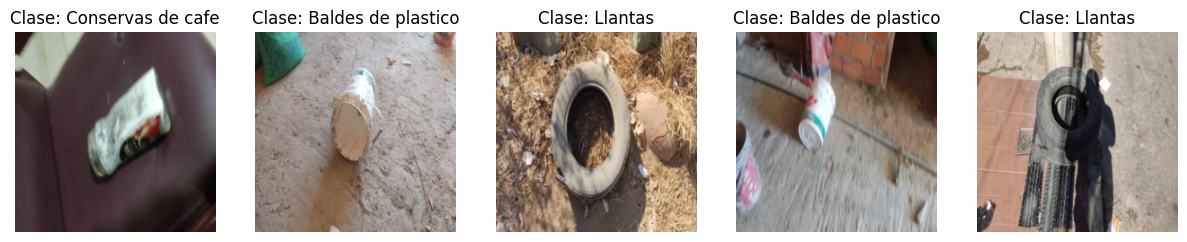

In [3]:
indices = random.sample(range(len(train_dataset)), 5)

plt.figure(figsize=(15,5))

for i, idx in enumerate(indices):
    image, label = train_dataset[idx]  # imagen y etiqueta
    image = image.permute(1,2,0).numpy()  # cambiar de CxHxW a HxWxC
    image = (image * 0.5) + 0.5  # desnormalizar
    plt.subplot(1,5,i+1)
    plt.imshow(image)
    plt.title(f"Clase: {train_dataset.classes[label]}")
    plt.axis('off')

plt.show()

## Implementación de la Clase LoRALinear

La clase `LoRALinear` implementa la técnica **LoRA (Low-Rank Adaptation)** para redes neuronales profundas.  
Su propósito es **reducir los parámetros entrenables** durante el fine-tuning de modelos grandes, manteniendo la precisión y reduciendo el consumo de memoria.

---

### Fundamento Teórico

En una capa lineal tradicional, la salida \( y \) se calcula como:

\[
y = xW + b
\]

donde:
- $x \in \mathbb{R}^{B \times d}$: entrada (batch × dimensión de entrada)
- $W \in \mathbb{R}^{d \times k}$: matriz de pesos original
- $b \in \mathbb{R}^{k}$: sesgo (bias)
- $y \in \mathbb{R}^{B \times k}$: salida de la capa

---

### Adaptación LoRA

En **LoRA**, no se actualiza directamente la matriz $W$.  
En su lugar, se mantiene **congelada** y se agrega una **corrección de bajo rango**:

$$
W' = W + \Delta W
$$

donde la actualización se define como:

$$
\Delta W = BA
$$

con:

- $A \in \mathbb{R}^{r \times d}$
- $B \in \mathbb{R}^{k \times r}$
- $r \ll \min(d, k)$, es decir, de **bajo rango**


Esto permite reducir los parámetros entrenables de $d \times k$ a $r(d + k)$,  
lo cual es **mucho menor** cuando $r$ es pequeño (por ejemplo, 4 o 8).

---

### Cálculo en la Implementación

En la clase `LoRALinear`, el cálculo de la salida se realiza como:

$$
y = \text{orig\_layer}(x) + \text{scaling} \cdot (x A B)
$$

$$
y = \left(W_{\text{quant}} + \frac{\alpha}{r} BA\right)x
$$

donde:
- `orig_layer(x)` representa la salida original del modelo (no entrenable)
- $A = \text{lora\_A} \in \mathbb{R}^{d \times r}$
- $B = \text{lora\_B} \in \mathbb{R}^{r \times k}$
- `scaling = α / r` es un factor de normalización para estabilizar el entrenamiento

El término adicional $xAB$ actúa como una corrección aprendida de bajo rango.


In [ ]:
# Implementación de LoRA
class LoRALinear(nn.Module):
    def __init__(self, orig_layer, r=4, alpha=16):
        super().__init__()
        self.orig_layer = orig_layer # Capa lineal original
        self.r = r # Rango bajo
        self.alpha = alpha # Escalado
        self.scaling = alpha / r # Factor de escalado
        self.lora_A = nn.Parameter(torch.zeros(orig_layer.in_features, r)) # Matriz A
        self.lora_B = nn.Parameter(torch.zeros(r, orig_layer.out_features)) # Matriz B

        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5)) # Inicializamos A con Kaiming
        nn.init.zeros_(self.lora_B) # Inicializamos B con ceros

    def forward(self, x): 
        return self.orig_layer(x) + self.scaling * (x @ self.lora_A @ self.lora_B) # Aplicamos la formula de LoRA que es W + BA

## Carga del modelo VIT

En esta parte cargamos el modelo preentrenado, ajustando la salida a 5 clases que es nuestra cantidad de clases en el dataset. Pasando una capa Lineal a la clase **LoRALinear**.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Dispositivo

# Carga del modelo VIT preentrenado
model = models.vit_b_16(pretrained=True)

# Ajuste de la capa final para 5 clases usando LoRA
num_classes = 5
orig_linear = nn.Linear(model.heads.head.in_features, num_classes) # Nueva capa lineal

model.heads.head = LoRALinear(orig_linear, r=4) # Reemplazamos la capa final con LoRA
model = model.to(device) # Movemos el modelo al dispositivo

print(model.heads.head.orig_layer.out_features) # Verificamos que la salida sea 5

d:\Programs\Python\3.12.7\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Programs\Python\3.12.7\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


5


## Entrenamiento del Modelo

Aqui entrenamos el modelo con solo 3 epocas

In [ ]:
num_epochs = 3
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

for epoch in range(num_epochs):
    # ----------- Entrenamiento -----------
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    loop = tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{num_epochs}", leave=True)
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
        loop.set_postfix(loss=loss.item(), acc=100*correct_train/total_train)
    
    train_loss = total_train_loss / len(train_loader)
    train_acc  = 100 * correct_train / total_train
    
    # ----------- Validación -----------
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            total_val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    
    val_loss = total_val_loss / len(val_loader)
    val_acc  = 100 * correct_val / total_val
    
    print(f"📊 Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Train Epoch 1/3: 100%|██████████| 2501/2501 [17:35<00:00,  2.37it/s, acc=68.3, loss=0.0931]


📊 Epoch 1/3 | Train Loss: 0.7899, Train Acc: 68.30% | Val Loss: 0.2482, Val Acc: 91.30%


Train Epoch 2/3: 100%|██████████| 2501/2501 [17:35<00:00,  2.37it/s, acc=92.1, loss=0.262]  


📊 Epoch 2/3 | Train Loss: 0.2281, Train Acc: 92.12% | Val Loss: 0.4317, Val Acc: 82.80%


Train Epoch 3/3: 100%|██████████| 2501/2501 [17:35<00:00,  2.37it/s, acc=94.8, loss=0.0562]  


📊 Epoch 3/3 | Train Loss: 0.1500, Train Acc: 94.81% | Val Loss: 0.1084, Val Acc: 95.94%


### Guardado del Modelo

In [7]:
torch.save(model.state_dict(), "modelo_lora.pt")
print("✅ Modelo guardado en modelo_lora.pt")

✅ Modelo guardado en modelo_lora.pt


## Prueba del Modelo entrenado con LoRA

Aqui cargamos el mismo modelo preentrenado, luego reemplamos la cabeza con la misma estructura del entranmiento el cuaal contiene 5 clases, luego cargamos los pesos entrenados:

In [ ]:
# Carga del modelo VIT preentrenado
model = models.vit_b_16(pretrained=True)

# Reemplazar la cabeza con la misma estructura del entrenamiento (5 clases)
model.heads.head = LoRALinear(nn.Linear(768, 5), r=4).to(device)

# Cargar pesos entrenados
model.load_state_dict(torch.load("modelo_lora.pt", map_location=device))

# Mover el modelo al dispositivo y poner en modo evaluación
model = model.to(device)
model.eval()
print("✅ Modelo cargado correctamente con 5 clases.")

C:\Users\Animetx\AppData\Local\Temp\ipykernel_8080\3436152881.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("modelo_lora.pt", map_loca

✅ Modelo cargado correctamente con 5 clases.


### Prediccion de una Imagen

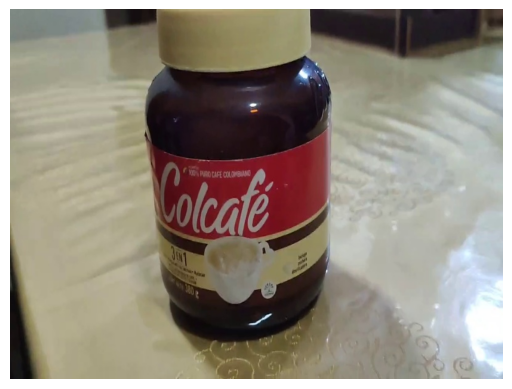

💡 Predicción: Conservas de cafe


In [9]:
from PIL import Image

image_path = r"D:\Ciencias\Dataset Residuos solidos\data\val\Conservas de cafe\0kwsf7ocvacy26xo.jpg"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# Mostrar imagen
plt.imshow(image)
plt.axis("off")
plt.show()

# Predicción
with torch.no_grad():
    outputs = model(input_tensor)
    _, pred = torch.max(outputs, 1)

print(f"💡 Predicción: {train_dataset.classes[pred.item()]}")